# Imports

In [1]:
import gymnasium as gym
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import namedtuple, deque
from itertools import count
from gymnasium.wrappers import FlattenObservation

days = 7
day_offset = 20
charge_penatly_mwh = 0.0

env_train = gym.make('gym_environment:gym_environment/SimpleBattery', days=days, predict=True, day_offset=day_offset, charge_penalty_mwh=charge_penatly_mwh)
env_train = FlattenObservation(env_train)

# setup plots
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# Select correct torch device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

# DQN Model

In [5]:
"""
Transition: named tuple representing a single transition in the environment
    maps the (state, action) pairs to their (next_state,reward) result

ReplayMemory: a cyclic buffer that holds the transitions oberved recetly.
    Also has a .sample() method for selecting a random batch of transition for training

"""

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """ Save a transition """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    

class GetLSTMoutput(nn.Module):
    def forward(self, x):
        out, _ = x
        return out


""" Custom DQN module using Q-learning """
class DQN(nn.Module):   
    def __init__(self, observation_shape, n_actions, env, EPS_END, EPS_START, EPS_DECAY):
        super(DQN, self).__init__()

        # Innit variables
        self.env = env
        self.EPS_END = EPS_END
        self.EPS_START = EPS_START
        self.EPS_DECAY = EPS_DECAY

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=observation_shape[0], out_channels=32, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1),
            nn.ReLU(),
        )
        # Calculate the shape of the output from the convolutional layers
        conv_output_size = self._get_conv_output_size(observation_shape)
        
        self.rnn_layers = nn.Sequential(
            nn.LSTM(input_size=conv_output_size, hidden_size=64, batch_first=True),
            GetLSTMoutput(),
            nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    
    def _get_conv_output_size(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.conv_layers(input)
        conv_output_size = output_feat.data.view(batch_size, -1).size(1)
        return conv_output_size
    
    # TODO: random needs a seed for reproducability ?
    def select_action(self, state, predict = False):
        global steps_done
        sample = random.random()
        if not predict:
            eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
                math.exp(-1 * steps_done / self.EPS_DECAY)
        else:
            eps_threshold = -1
        steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.forward(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the RNN
        x, _ = self.rnn_layers(x.unsqueeze(1))  # Add a time dimension (batch_size, seq_len, input_size)
        x = x.squeeze(1)  # Remove the time dimension
        x = self.fc_layers(x)
        return x
    

""" Model Definition """
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 1440
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-4

# Get number of action from gym action space
n_actions = env_train.action_space.n
# Get number of state observations
state, info = env_train.reset()
observation_shape = observation_shape = np.array(env_train.observation_space.sample()).reshape((-1,1)).shape

model_policy = DQN(observation_shape, n_actions, env_train, EPS_END, EPS_START, EPS_DECAY).to(device)
model_target = DQN(observation_shape, n_actions, env_train, EPS_END, EPS_START, EPS_DECAY).to(device)
model_target.load_state_dict(model_policy.state_dict())

optimizer = optim.AdamW(model_policy.parameters(), lr=LR, amsgrad=True)

#TODO: Add to DQN class ?
memory = ReplayMemory(10000)

steps_done = 0

episode_rewards = []

def plot_durations(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())

    # Take 50 ep. Average and plot them
    if len(rewards_t) >= 50:
        means = rewards_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy())

    plt.pause(0.0001) # pause a bit to update plots
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True) 
        else:
            display.display(plt.gcf())

## Simplified Network

In [15]:
"""
Transition: named tuple representing a single transition in the environment
    maps the (state, action) pairs to their (next_state,reward) result

ReplayMemory: a cyclic buffer that holds the transitions oberved recetly.
    Also has a .sample() method for selecting a random batch of transition for training

"""

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """ Save a transition """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    

class GetLSTMoutput(nn.Module):
    def forward(self, x):
        out, _ = x
        return out


""" Custom DQN module using Q-learning """
class Simplified_DQN(nn.Module):   
    def __init__(self, observation_shape, n_actions, env, EPS_END, EPS_START, EPS_DECAY):
        super(Simplified_DQN, self).__init__()

        # Innit variables
        self.env = env
        self.EPS_END = EPS_END
        self.EPS_START = EPS_START
        self.EPS_DECAY = EPS_DECAY

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=observation_shape[0], out_channels=32, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1),
            nn.ReLU(),
        )
        # Calculate the shape of the output from the convolutional layers
        conv_output_size = self._get_conv_output_size(observation_shape)
        
        self.lstm = nn.LSTM(input_size=conv_output_size, hidden_size=64, batch_first=True)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    
    def _get_conv_output_size(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.conv_layers(input)
        conv_output_size = output_feat.data.view(batch_size, -1).size(1)
        return conv_output_size
    
    # TODO: random needs a seed for reproducability ?
    def select_action(self, state, predict = False):
        global steps_done
        sample = random.random()
        if not predict:
            eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
                math.exp(-1 * steps_done / self.EPS_DECAY)
        else:
            eps_threshold = -1
        steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.forward(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the RNN
        x, _ = self.lstm(x.unsqueeze(1))  # Add a time dimension (batch_size, seq_len, input_size)
        x = x.squeeze(1)  # Remove the time dimension
        x = self.fc_layers(x)
        return x
    

""" Model Definition """
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 1440
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-4

# Get number of action from gym action space
n_actions = env_train.action_space.n
# Get number of state observations
state, info = env_train.reset()
observation_shape = np.array(env_train.observation_space.sample()).reshape((-1,1)).shape

model_policy = Simplified_DQN(observation_shape, n_actions, env_train, EPS_END, EPS_START, EPS_DECAY).to(device)
model_target = Simplified_DQN(observation_shape, n_actions, env_train, EPS_END, EPS_START, EPS_DECAY).to(device)
model_target.load_state_dict(model_policy.state_dict())

optimizer = optim.AdamW(model_policy.parameters(), lr=LR, amsgrad=True)

#TODO: Add to DQN class ?
memory = ReplayMemory(10000)

steps_done = 0

episode_rewards = []

def plot_durations(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())

    # Take 50 ep. Average and plot them
    if len(rewards_t) >= 50:
        means = rewards_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy())

    plt.pause(0.0001) # pause a bit to update plots
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True) 
        else:
            display.display(plt.gcf())

# DQN Training

In [3]:
""" 
Training the DQN model

Hyperparameters 

select_action: will select an action according to an e-greedy policy
plot_duration: helper function for plotting the duration of episodes, 
    along with the average over the last 50 episodes
"""

#TODO: This needs to be better so the model can actually converge
    # Maybe no need to make it "converge" but predict on a select few days, maybe 10-20 total and plot reward over those

""" Training Loop """
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch. 
    # Converts batch-array of Transitions to Transitions of batch-arrays
    batch = Transition(*zip(*transitions))

    # Cumpute mask of non-final stats and concatenate the batch elements
    # (a final state would've been the one after which the simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                        if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = model_policy(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = model_target(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(model_policy.parameters(), 100)
    optimizer.step()

""" Number of training episodes """
num_episodes = 400

try:
    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state, info = env_train.reset()

        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(2)

        total_r = 0
        epr = []

        for t in count():
            action = model_policy.select_action(state)
            observation, reward, terminated, truncated, info = env_train.step(action.item())
            total_r += reward
            epr.append(reward)
            reward = torch.tensor([reward], dtype=torch.float32, device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(2)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()


            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = model_target.state_dict()
            policy_net_state_dict = model_policy.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            model_target.load_state_dict(target_net_state_dict)

            if done:
                episode_rewards.append(total_r)
                plot_durations(show_result=True)
                break

    print('Complete')
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()
except KeyboardInterrupt:
    torch.save(model_policy.state_dict(), './models/DQN_{}score_{}ep_{}days{}_{}pen.pt'.format(round(np.sum(epr)), i_episode, days, day_offset, charge_penatly_mwh))

<Figure size 640x480 with 0 Axes>

## Save Model

In [ ]:
torch.save(model_policy.state_dict(), './models/DQN_50_week38_7day_pen0.pt')

## Load Model

In [13]:
model_policy.load_state_dict(torch.load('./models/DQN_400_1day_pen8.pt', map_location=device))
model_policy.eval()

DQN(
  (conv_layers): Sequential(
    (0): Conv1d(393, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (5): ReLU()
  )
  (rnn_layers): Sequential(
    (0): LSTM(128, 64, batch_first=True)
    (1): GetLSTMoutput()
    (2): LSTM(64, 32, batch_first=True)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)

# Model Predictions

## Test Variables

In [2]:
day_offset = 20
days = 7
year = 2023

start_offset = day_offset * 1440

test_env = gym.make('gym_environment:gym_environment/SimpleBattery', days=days, predict=True, day_offset=day_offset, year=year)
test_env = FlattenObservation(test_env)

# Load data
current_folder = globals()['_dh'][0]
data_path = os.path.join(current_folder, "./data/backend/{}/test_imb.csv".format(year))
test_imb = pd.read_csv(data_path)

capacity = 2000.0
charge_rate = 1000.0
kW_min = charge_rate / 60.0

## DQN Model

In [28]:
dqn_kwh_take = []
dqn_kwh_give = []
dqn_reward = []
dqn_soc = []
episode_energy_price = []
i = 0

total_dqn_reward = 0
total_dqn_imbalance_reward = 0

state,info = test_env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(2)

terminated = False

while not terminated:
    action = model_policy.select_action(state, predict=True)
    observation, reward, terminated, truncated, info = test_env.step(action.item())

    total_dqn_reward+=reward
    done = terminated or truncated

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(2)

        # Store action and dates
        soc_change = info['soc_change']
        if action.item() == 0 and soc_change:
            dqn_kwh_take.append(kW_min)
            dqn_kwh_give.append(0)
        elif action.item() == 1 and soc_change:
            dqn_kwh_take.append(0)
            dqn_kwh_give.append(kW_min)
        else:
            dqn_kwh_take.append(0)
            dqn_kwh_give.append(0)
        episode_energy_price.append(info['imb']['imbalance_take_price'])
        total_dqn_imbalance_reward += info['imbalance_reward']
        dqn_reward.append(info['imbalance_reward'])

        dqn_soc.append(observation[0])
        # print("SOC: {} Reward: {}".format(observation[0], reward.item()))

    # Move to the next state
    i+=1
    state = next_state
print("Reward:{}".format(total_dqn_reward))
print("Imbalance Reward:{}".format(total_dqn_imbalance_reward))
print("Difference:{}".format(round(total_dqn_reward / total_dqn_imbalance_reward, 4)))

Reward:105355.9216666838
Imbalance Reward:149311.12533333016
Difference:0.7056


In [19]:
# Amount of cyles
total_dqn_take = np.sum(dqn_kwh_take)
total_dqn_give = np.sum(dqn_kwh_give)
cycles = (total_dqn_take + total_dqn_give) / (capacity * 2)
print(cycles)

27.26666666666667


## A3C Model

In [3]:
import glob
import json
from A3C_agent_no_replay import ActorCritic

old_device = device
device = 'cpu'
folder_path = "./models/A3C"


def load_hypers(model_path):
    model_name = os.path.basename(model_path)
    basename_name = os.path.splitext(model_name)[0]
    hyper_path = os.path.join('./models/A3C/hyper_params', "{}.json".format(basename_name))
    with open(hyper_path, "r") as json_file:
        data = json.load(json_file)
    return data

for file_path in glob.glob(folder_path + "/*.pt"):
    file_path = "./models/A3C/A3C_103score_444ep_7days20_0.0pen.pt"
    
    print("Processing file: ", file_path)

    hyper_params = load_hypers(file_path)

    A3C = ActorCritic(test_env.observation_space.shape[0], test_env.action_space.n, hyper_params['hidden_size'], hyper_params['gamma'])
    A3C.load_state_dict(torch.load(file_path, map_location=device))
    A3C.eval()

    a3c_kwh_take = []
    a3c_kwh_give = []
    a3c_reward = []
    a3c_soc = []
    episode_energy_price = []
    i = 0

    total_a3c_reward = 0
    total_a3c_imbalance_reward = 0

    state,info = test_env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    hx = torch.zeros(1, hyper_params['hidden_size'])
    cx = torch.zeros(1, hyper_params['hidden_size'])    

    terminated = False

    while not terminated:
        with torch.no_grad():
            pi, _, (hx, cx) = A3C(state.unsqueeze(0), hx, cx)
        
        prob = F.softmax(pi, dim=1)
        action = prob.cpu().numpy().argmax()

        observation, reward, terminated, truncated, info = test_env.step(action)

        total_a3c_reward+=reward
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            soc_change = info['soc_change']
            # Store action and dates
            if action.item() == 0 & soc_change:
                a3c_kwh_take.append(kW_min)
                a3c_kwh_give.append(0)
            elif action.item() == 1 & soc_change:
                a3c_kwh_take.append(0)
                a3c_kwh_give.append(kW_min)
            else:
                a3c_kwh_take.append(0)
                a3c_kwh_give.append(0)
            episode_energy_price.append(info['imb']['imbalance_take_price'])
            total_a3c_imbalance_reward += info['imbalance_reward']
            a3c_reward.append(info['imbalance_reward'])

            a3c_soc.append(observation[0])
            # print("SOC: {} Reward: {}".format(observation[0], reward))

        ac_str = ""
        if action.item() == 0:
            ac_str = "take"
        elif action.item() == 1:
            ac_str = "feed"
        else:
            ac_str = "hold"

        if test_imb['imbalance_regulation_state'][start_offset + i] == -2:
            print("Action: {} Reward: {}".format(ac_str, reward))
            print("Time: {}".format(test_imb['time'][start_offset + i]))
            print("Feed price: {}".format(test_imb['high_feed_price'][start_offset + i]))
            print("Take price: {}".format(test_imb['low_take_price'][start_offset + i]))
            print("Mid price: {}".format(test_imb['mid_price'][start_offset + i]))
            print("Imbalance feed: {}".format(test_imb['imbalance_feed_price'][start_offset + i]))
            print("Imbalance take: {}".format(test_imb['imbalance_take_price'][start_offset + i]))
            print("Imbalance state: {}".format(test_imb['imbalance_regulation_state'][start_offset + i]))

            print("Observation feed: {}".format(observation[2]))
            print("Observation take: {}".format(observation[3]))
            print("Observation SOC: {}".format(observation[0]))
            print("----")
        # Move to the next state
        i+=1
        state = next_state

    # Amount of cyles
    total_a3c_take = np.sum(a3c_kwh_take)
    total_a3c_give = np.sum(a3c_kwh_give)
    cycles = (total_a3c_take + total_a3c_give) / (capacity * 2)
    print("Reward:{}".format(round(total_a3c_reward, 1)))
    print("Imbalance Reward:{} Cycles:{}".format(round(total_a3c_imbalance_reward,1), round(cycles, 1)))
    # print("Difference:{}".format(round(total_a3c_reward / total_a3c_imbalance_reward, 4)))
    break

device = old_device

Processing file:  ./models/A3C/A3C_103score_444ep_7days20_0.0pen.pt
Reward:114.5
Imbalance Reward:129.9 Cycles:0.2


## Baseline Model

In [19]:
def state_to_dict(state_array):
    state = {
        'battery_charge': state_array[0],
        'day_of_week': state_array[1],
        'energy_feed_price': state_array[2],
        'energy_take_price': state_array[3],
        'hour_of_day': state_array[4],
        'mid_price': state_array[5],
        'month': state_array[6],
    }
    return state

baseline_kwh_take = []
baseline_kwh_give = []
baseline_reward = []
baseline_soc = []
i = 0

total_baseline_reward = 0
total_baseline_imbalance_reward = 0

state, info = test_env.reset()

terminated = False

# Define the winter and summer periods
winter_start = pd.to_datetime('10/01', format='%m/%d').month
winter_end = pd.to_datetime('03/01', format='%m/%d').month

# config = {'charge_winter': -14.783232243425344, 
#  'discharge_winter': 54.465705741287394, 
#  'charge_summer': 16.19267672872887, 
#  'discharge_summer': 50.20564418513649, 
#  'charge_winter_night': 19.830706694089418, 
#  'discharge_winter_night': 20.185944997256925, 
#  'charge_summer_night': 5.56931301624121, 
#  'discharge_summer_night': 20.15069553603697}

config = {'charge_winter': -5, 
 'discharge_winter': 60, 
 'charge_summer': -5, 
 'discharge_summer': 60, 
 'charge_winter_night': -5, 
 'discharge_winter_night': 60, 
 'charge_summer_night': -5, 
 'discharge_summer_night': 60}

while not terminated:
    m = start_offset + i
    state = state_to_dict(state)

    # Select action using Baseline rules
    # Determine if the date is in winter or summer

    if (state['month'] >= winter_start) or (state['month'] < winter_end):
        if 0 <= state['hour_of_day'] < 6:
            if (state['energy_feed_price'] - state['mid_price']) >= config['discharge_winter_night']:
                action = 1
            elif (state['energy_take_price'] - state['mid_price']) <= config['charge_winter_night']:
                action = 0
            else:
                action = 2
        else:
            if (state['energy_feed_price'] - state['mid_price']) >= config['discharge_winter']:
                action = 1
            elif (state['energy_take_price'] - state['mid_price']) <= config['charge_winter']:
                action = 0
            else:
                action = 2            
    else:
        if 0 <= state['hour_of_day'] < 6:
            if (state['energy_feed_price'] - state['mid_price']) >= config['discharge_summer_night']:
                action = 1
            elif (state['energy_take_price'] - state['mid_price']) <= config['charge_summer_night']:
                action = 0
            else:
                action = 2  
        else:
            if (state['energy_feed_price'] - state['mid_price']) >= config['discharge_summer']:
                action = 1
            elif (state['energy_take_price'] - state['mid_price']) <= config['charge_summer']:
                action = 0
            else:
                action = 2  


    next_state, reward, terminated, truncated, info = test_env.step(action)

    total_baseline_reward+=reward
    done = terminated or truncated
    if pd.isnull(reward):
        print(state)

    if not terminated:
        # Store action and dates
        if action == 0:
            baseline_kwh_take.append(kW_min)
            baseline_kwh_give.append(0)
        elif action == 1:
            baseline_kwh_take.append(0)
            baseline_kwh_give.append(kW_min)
        else:
            baseline_kwh_take.append(0)
            baseline_kwh_give.append(0)

        total_baseline_imbalance_reward += info['imbalance_reward']
        baseline_reward.append(info['imbalance_reward'])

        baseline_soc.append(next_state[0])
        # print("SOC: {} Reward: {}".format(next_state[0], reward.item()))

    # Move to the next state
    i+=1
    state = next_state
    # print("Minute: {}, Reward: {}".format(i, imbalance_reward))
print("Reward:{}".format(total_baseline_reward))
print("Imbalance Reward:{}".format(total_baseline_imbalance_reward))
print("Difference:{}%".format(round((total_baseline_imbalance_reward / total_baseline_reward - 1) * 100.0), 4))

Reward:3414.3540566666625
Imbalance Reward:3919.66216666668
Difference:15%


In [9]:
# Amount of cyles
total_baseline_take = np.sum(baseline_kwh_take)
total_baseline_give = np.sum(baseline_kwh_give)
cycles = (total_baseline_take + total_baseline_give) / (capacity * 2)
print(cycles)

0.675


# Analyzing DQN Model

NameError: name 'dqn_kwh_take' is not defined

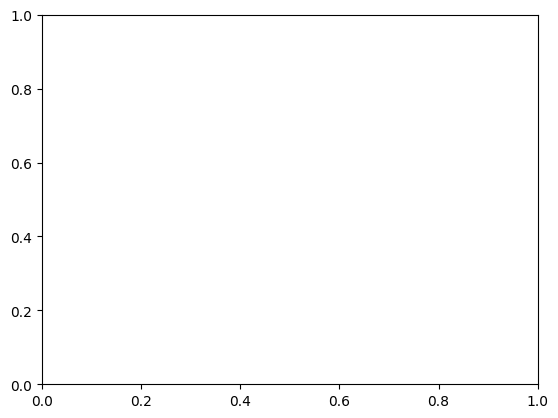

In [9]:
fig, ax1 = plt.subplots()
days = np.int64(len(episode_energy_price)/1440)

daily_take = np.array(dqn_kwh_take).reshape(days, 24, 60)
daily_give = np.array(dqn_kwh_give).reshape(days, 24, 60)
daily_price = np.array(episode_energy_price).reshape(days, 24, 60)

hourday_average_take = np.sum(daily_take, axis = 2)
hourday_average_give = np.sum(daily_give, axis = 2)
hourday_average_price = np.mean(daily_price, axis = 2)

overall_hour_take = np.sum(hourday_average_take, axis = 0)
overall_hour_give = np.sum(hourday_average_give, axis = 0)
overall_hour_price = np.mean(hourday_average_price, axis = 0)

x = range(24)

color = 'k'
ax1.set_xlabel('Time (m)')
ax1.set_ylabel('Energy (kW)', color=color)
ax1.bar(x, overall_hour_give, color='tab:blue', alpha=1)
ax1.bar(x, overall_hour_take, color='tab:red', alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'k'
ax2.set_ylabel('Energy price (euro)', color=color)
ax2.plot(overall_hour_price, color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Percentage of takes above threshhold: 0.4524, Threshold: 10


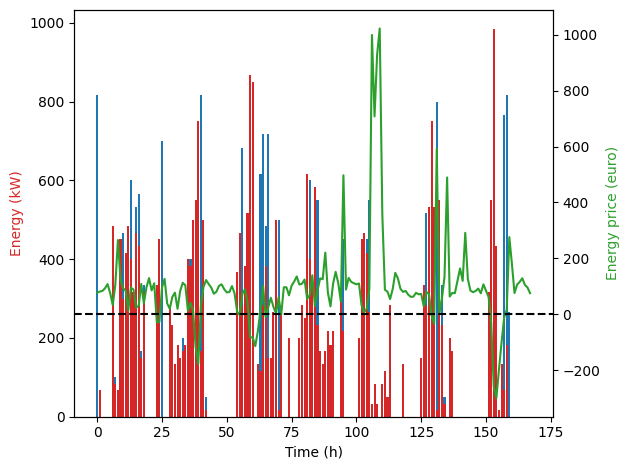

In [11]:
fig, ax1 = plt.subplots()

days = np.int64(len(episode_energy_price)/1440)

daily_take = np.array(dqn_kwh_take).reshape(days, 24, 60)
daily_give = np.array(dqn_kwh_give).reshape(days, 24, 60)
daily_price = np.array(episode_energy_price).reshape(days, 24, 60)

hourday_average_take = np.sum(daily_take, axis = 2)
hourday_average_give = np.sum(daily_give, axis = 2)
hourday_average_price = np.mean(daily_price, axis = 2)

overall_hour_take = hourday_average_take.flatten()
overall_hour_give = hourday_average_give.flatten()
overall_hour_price = hourday_average_price.flatten()

threshold = 10

oht_filtered = [overall_hour_take[i] if overall_hour_price[i] > threshold else 0 for i in range(len(overall_hour_take))]

print("Percentage of takes above threshhold: {}, Threshold: {}".format(round((len(oht_filtered) - oht_filtered.count(0)) / len(oht_filtered),4), threshold))

x = range(24*days)

color = 'k'
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Energy (kW)', color='tab:red')
ax1.bar(x, overall_hour_give, color='tab:blue', alpha=1)
ax1.bar(x, overall_hour_take, color='tab:red', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'k'
ax2.set_ylabel('Energy price (euro)', color='tab:green')
ax2.plot(overall_hour_price, color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# De plot is niet super duidelijk, maar dit is de prediction over een week. In het groen is de energie prijs en in rood is de

# Analyzing A3C Model

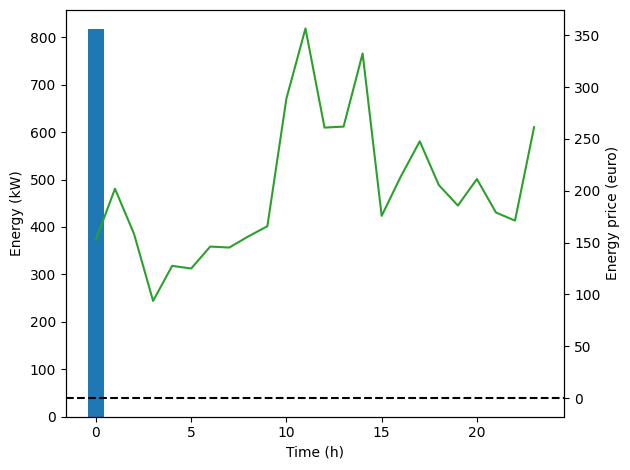

In [4]:
fig, ax1 = plt.subplots()
days = np.int64(len(episode_energy_price)/1440)

daily_take = np.array(a3c_kwh_take).reshape(days, 24, 60)
daily_give = np.array(a3c_kwh_give).reshape(days, 24, 60)
daily_price = np.array(episode_energy_price).reshape(days, 24, 60)

hourday_average_take = np.sum(daily_take, axis = 2)
hourday_average_give = np.sum(daily_give, axis = 2)
hourday_average_price = np.mean(daily_price, axis = 2)

overall_hour_take = np.sum(hourday_average_take, axis = 0)
overall_hour_give = np.sum(hourday_average_give, axis = 0)
overall_hour_price = np.mean(hourday_average_price, axis = 0)

x = range(24)

color = 'k'
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Energy (kW)', color=color)
ax1.bar(x, overall_hour_give, color='tab:blue', alpha=1)
ax1.bar(x, overall_hour_take, color='tab:red', alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'k'
ax2.set_ylabel('Energy price (euro)', color=color)
ax2.plot(overall_hour_price, color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# Comparing Baseline and DQN

Improvement over baseline: -40.05481547206888%


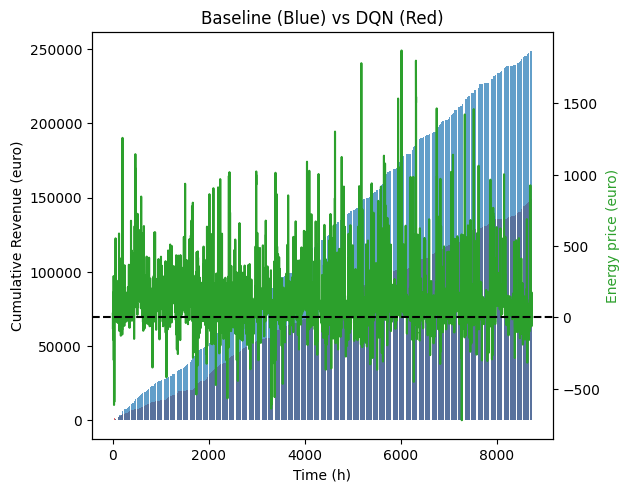

In [31]:
fig, ax1 = plt.subplots()

days = np.int64(len(episode_energy_price)/1440)

print("Improvement over baseline: {}%".format((total_dqn_imbalance_reward / total_baseline_imbalance_reward - 1) * 100))

dqn_reward = np.array(dqn_reward).reshape(days, 24, 60)
baseline_reward = np.array(baseline_reward).reshape(days, 24, 60)
daily_price = np.array(episode_energy_price).reshape(days, 24, 60)

hourday_dqn_reward = np.sum(dqn_reward, axis = 2)
hourday_baseline_reward = np.sum(baseline_reward, axis = 2)
hourday_average_price = np.mean(daily_price, axis = 2)

overall_dqn_reward = np.cumsum(hourday_dqn_reward.flatten())
overall_baseline_reward = np.cumsum(hourday_baseline_reward.flatten())
overall_hour_price = hourday_average_price.flatten()

x = range(24*days)

color = 'k'
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Cumulative Revenue (euro)', color='k')
# ax1.bar(x, overall_hour_give, color='tab:blue', alpha=1)
ax1.bar(x, overall_dqn_reward, color='tab:red', alpha=0.7)
ax1.bar(x, overall_baseline_reward, color='tab:blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'k'
ax2.set_ylabel('Energy price (euro)', color='tab:green')
ax2.plot(overall_hour_price, color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Baseline (Blue) vs DQN (Red)")
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

## Calculate weeks with highest difference to Baseline


In [34]:
""" 
    Use these weeks to train a new model and compare the performance of the models 
    Known problem: model sells and never keeps any energy in case the price spikes a lot
      Solution: Have higher energy capacity
                Buy more energy
                Keep energy on hand just in case
                Somehow make the model learn long term dependencies better
"""

dqn_weekly_reward = np.array(dqn_reward).reshape(-1, 7*1440)
baseline_weekly_reward = np.array(baseline_reward).reshape(-1, 7*1440)

dqn_weekly_average = np.mean(dqn_weekly_reward, axis=1)
baseline_weekly_average = np.mean(baseline_weekly_reward, axis=1)

differences = np.abs(baseline_weekly_average - dqn_weekly_average)

highest_difference_indices = np.argsort(differences)[::-1]

# Get the weeks with the highest differences
weeks_with_highest_differences = highest_difference_indices[:10]  # Adjust the number of weeks as needed

print("Weeks with the highest differences:")
for week_idx in weeks_with_highest_differences:
    print(f"Week {week_idx + 1}: Difference = {differences[week_idx]}")

Weeks with the highest differences:
Week 34: Difference = 0.8257376653439155
Week 36: Difference = 0.6830082175925927
Week 25: Difference = 0.675886292989418
Week 10: Difference = 0.5675911706349207
Week 41: Difference = 0.49022202380952395
Week 43: Difference = 0.4735495205026456
Week 28: Difference = 0.42943915343915334
Week 21: Difference = 0.39321135912698413
Week 2: Difference = 0.3616226521164022
Week 38: Difference = 0.35697979497354493


# Comparing Baseline and A3C

Improvement over baseline: -53.04667419389193%


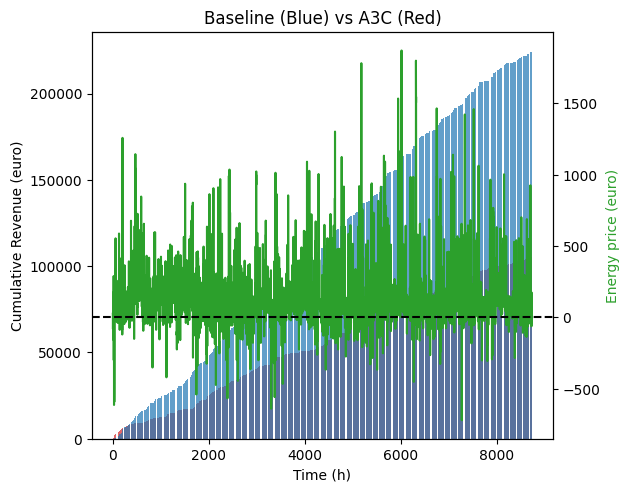

In [16]:
fig, ax1 = plt.subplots()

days = np.int64(len(episode_energy_price)/1440)

print("Improvement over baseline: {}%".format((total_a3c_imbalance_reward / total_baseline_imbalance_reward - 1) * 100))

a3c_reward = np.array(a3c_reward).reshape(days, 24, 60)
baseline_reward = np.array(baseline_reward).reshape(days, 24, 60)
daily_price = np.array(episode_energy_price).reshape(days, 24, 60)

hourday_a3c_reward = np.sum(a3c_reward, axis = 2)
hourday_baseline_reward = np.sum(baseline_reward, axis = 2)
hourday_average_price = np.mean(daily_price, axis = 2)

overall_a3c_reward = np.cumsum(hourday_a3c_reward.flatten())
overall_baseline_reward = np.cumsum(hourday_baseline_reward.flatten())
overall_hour_price = hourday_average_price.flatten()

x = range(24*days)

color = 'k'
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Cumulative Revenue (euro)', color='k')
# ax1.bar(x, overall_hour_give, color='tab:blue', alpha=1)
ax1.bar(x, overall_a3c_reward, color='tab:red', alpha=0.7)
ax1.bar(x, overall_baseline_reward, color='tab:blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'k'
ax2.set_ylabel('Energy price (euro)', color='tab:green')
ax2.plot(overall_hour_price, color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Baseline (Blue) vs A3C (Red)")
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

NameError: name 'total_dqn_imbalance_reward' is not defined

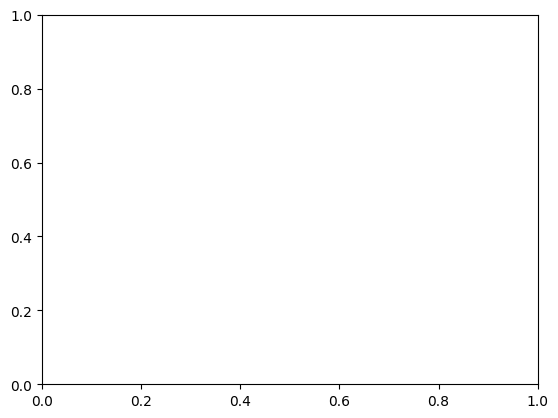

In [21]:
fig, ax1 = plt.subplots()

days = np.int64(len(episode_energy_price)/1440)

print("Improvement over baseline: {}%".format((total_dqn_imbalance_reward / total_baseline_imbalance_reward - 1) * 100))

dqn_reward = np.array(dqn_reward).reshape(days, 24, 60)
baseline_reward = np.array(baseline_reward).reshape(days, 24, 60)
daily_price = np.array(episode_energy_price).reshape(days, 24, 60)

hourday_dqn_reward = np.sum(dqn_reward, axis = 2)
hourday_baseline_reward = np.sum(baseline_reward, axis = 2)
hourday_average_price = np.mean(daily_price, axis = 2)

overall_dqn_reward = hourday_dqn_reward.flatten()
overall_baseline_reward = hourday_baseline_reward.flatten()
overall_hour_price = hourday_average_price.flatten()

x = range(24*days)

color = 'k'
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Energy (kW)', color='tab:red')
# ax1.bar(x, overall_hour_give, color='tab:blue', alpha=1)
ax1.bar(x, overall_dqn_reward, color='tab:red', alpha=1)
ax1.bar(x, overall_baseline_reward, color='tab:blue', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'k'
ax2.set_ylabel('Energy price (euro)', color='tab:green')
ax2.plot(overall_hour_price, color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# De plot is niet super duidelijk, maar dit is de prediction over een week. In het groen is de energie prijs en in rood is de

# Q-Learning Agent

In [ ]:
env = gym.make('gym_environment:gym_environment/GridWorld', render_mode=None, max_episode_steps=300)
env = FlattenObservation(env)

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

# Q-table zero init
q_table = np.zeros((n_observations, n_actions))
print(q_table)

n_episodes = 10000

# init exploration probablity
exploration_prob = 1

# exploraation decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.001

# minimum exploration probability
min_exploration_prob = 0.01

# discount factor
gamma = 0.99

# learning rate
lr = 0.1

# Q-Learning Training

In [ ]:
total_rewards_episode = list()

# Interating over the episodes
for e in range(n_episodes):
    # first state
    current_state, _ = env.reset()
    done = False

    # total reward
    total_reward = 0
    while not done:
        # implementing e-random
        if np.random.uniform(0,1) < exploration_prob:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[current_state,:], axis=1)
            if action.size > 1:
                action = random.choice(action)
        # Step in the env
        next_state, reward, terminated, truncated, info = env.step(action)

        # Update the Q table
        q_table[current_state, action] = (1-lr) * q_table[current_state, action] + lr*(reward + gamma*np.max(q_table[next_state,:]))

        total_reward = total_reward + reward

        done = terminated or truncated

        if done:
            next_state = None
        else:
            current_state = next_state 
    exploration_prob = max(min_exploration_prob, np.exp(-exploration_decreasing_decay*e))
    total_rewards_episode.append(total_reward)
        

In [ ]:
env = gym.make('gym_environment:gym_environment/GridWorld', render_mode='human', max_episode_steps=300)
env = FlattenObservation(env)

episodes = 10

for ep in range(episodes):
    current_state, info = env.reset()
    terminated = False

    while not terminated:
        action = np.argmax(q_table[current_state,:], axis=1)
        if action.size > 1:
            action = random.choice(action)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            current_state = next_state

        env.render()
